In [4]:
# from __future__ import print_function, division

In [2]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import lxml

from collections import OrderedDict

### STEP 1: Scrape NBA per minute stats + Advanced Stats

In [75]:
# function converts string to float
def convert_numeric(df, str_cols):
    for i in str_cols:
        df[i] = df[i].astype(float)
        
def scrape_per_min_stats(year):
    # main url - change year parameter to get different years
    url = 'https://www.basketball-reference.com/leagues/NBA_'+ str(year) + '_per_minute.html'
    response = requests.get(url)
    page = response.text
    
    soup = BeautifulSoup(page, "html.parser") 
    
    # grab correct col names
    cols =  soup.find('thead').text.split('\n')
    cols_clean = cols[3:-2]
    
    # start to collect data from table to list of lists
    table = soup.find('tbody')
    rows = table.find_all('tr')

    data1 = []
    for tr in rows:
        cols = tr.find_all('td')
        x = [td.text if td.getText() != '' else '0' for td in cols]
        data1.append(x)
        
    # convert to pandas DF
    Table = pd.DataFrame(data=data1, columns=cols_clean)
    
    # string cols to convert
    str_cols = [Table.columns[2]] + Table.columns[4:].tolist()

    # drop NAs, reset index
    Table.dropna(how='all', inplace=True)
    Table.reset_index(drop=True, inplace=True)
    
    # convert cols to numeric
    convert_numeric(Table, str_cols)
    
    # drop duplicates
    Table1 = Table.sort_values('G', ascending=False).drop_duplicates('Player').sort_index()
    Table1['Year'] = year

    return Table1


def scrape_advanced_stats(year):
    url = 'https://www.basketball-reference.com/leagues/NBA_' + str(year) + '_advanced.html'
    
    soup = BeautifulSoup(requests.get(url).text, "html.parser")
    table = soup.find('tbody')
    
    col_names = ['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr',\
          'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'DONOTUSE1',\
          'OWS', 'DWS', 'WS', 'WS/48', 'DONOTUSE2','OBPM', 'DBPM', 'BPM', 'VORP']
    
    # convert to list of lists
    rows = table.find_all('tr')

    data = []
    for tr in rows:
        cols = tr.find_all('td')
        x = [td.text if td.getText() != '' else '0' for td in cols]
        data.append(x)
       
    # convert to DF and add col names
    data_adv = pd.DataFrame(data=data, columns=col_names)
    
    # drop NAs, reset index
    data_adv.dropna(how='all', inplace=True)
    data_adv.reset_index(drop=True, inplace=True)
    
    # convert string cols to numeric
    str_cols = [data_adv.columns[2]] + data_adv.columns[4:].tolist()
    convert_numeric(data_adv, str_cols)

    # dedup - This happens if a player was on multiple teams in the same season
    data_adv = data_adv.sort_values('G', ascending=False).drop_duplicates('Player').sort_index()
    
    # drop unneeded cols
    data_adv = data_adv.drop(['Pos','Age', 'Tm', 'G', 'MP', 'DONOTUSE1', 'DONOTUSE2'], 1)

    return data_adv

In [76]:
# Create a dictionary of data for 2013-2017 seasons
# Merge per-min stats and advanced stats
year_start = 2013
year_end = 2017

print('Scraping Per Minute Stats and Advanced Stats')
print('Seasons', year_start, 'through', year_end, '\n')

years = range(year_start, year_end+1, 1)
data_stats = OrderedDict()

for year in years:
    print('Scraping', year)
    _df_per_min = scrape_per_min_stats(year)
    _df_advanced = scrape_advanced_stats(year)
    _df_merged = pd.merge(_df_per_min, _df_advanced, how='left', on=['Player'])
    _df_merged['Year'] = year
    print('Number of unique players', _df_merged.Player.nunique(), '\n')
    data_stats[year] = _df_merged

# Concat All DFs
df_all = pd.concat([df for year, df in data_stats.items()], ignore_index=True)
print('Done!')

Scraping Per Minute Stats and Advanced Stats
Seasons 2013 through 2017 

Scraping 2013
Number of unique players 468 

Scraping 2014
Number of unique players 481 

Scraping 2015
Number of unique players 492 

Scraping 2016
Number of unique players 476 

Scraping 2017
Number of unique players 486 

Done!


In [77]:
print('Sample Data (Transposed)')
df_all.head().T

Sample Data (Transposed)


,0,1,2,3,4
Player,Quincy Acy,Jeff Adrien,Arron Afflalo,Josh Akognon,Cole Aldrich
Pos,PF,PF,SF,PG,C
Age,22,26,27,26,24
Tm,TOR,CHA,ORL,DAL,TOT
G,29,52,64,3,45
GS,0,5,64,0,0
MP,342,713,2307,9,388
FG,4.4,3.6,6.2,8,4.1
FGA,7.9,8.5,14.1,16,7.4
FG%,0.56,0.429,0.439,0.5,0.55


In [20]:
df_all.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year_x', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Year_y'],
      dtype='object')

In [21]:
df_all.shape

(2403, 50)

### Generate Features Using 3 Year Avg of Stats

In [78]:
# For simplicity, merge 3 years together for 3 cohort years. This will be used for historical trends.
# ie. one cohort includes data from 2015, 2016, and 2017. The next includes data from 2014, 2015, and 2016, etc.

data_stats_15_17 = df_all[df_all.Year.between(2015, 2017, inclusive=True)]
data_stats_14_16 = df_all[df_all.Year.between(2014, 2016, inclusive=True)]
data_stats_13_15 = df_all[df_all.Year.between(2013, 2015, inclusive=True)]

print("shape, nunique")
print(data_stats_15_17.shape[0], data_stats_15_17.Player.nunique())
print(data_stats_14_16.shape[0], data_stats_14_16.Player.nunique())
print(data_stats_13_15.shape[0], data_stats_13_15.Player.nunique())


shape, nunique
1454 665
1449 654
1441 651


In [116]:
def three_year_avg(df, curr_year):
    # Compute 3 year Avg, Return current season stats and 3 year avg stats
    df_avg = df.groupby(['Player']).mean().reset_index()
    df_avg_merge = pd.merge(df, df_avg,
                             how='left', on=['Player'], 
                             sort=True, suffixes=('', '_3AVG'))
    return df_avg_merge[df_avg_merge['Year'] == curr_year].reset_index(drop=True)

# Append all Stats data together
stats_data_all = pd.concat([three_year_avg(data_stats_15_17, 2017),
                            three_year_avg(data_stats_14_16, 2016),
                            three_year_avg(data_stats_13_15, 2015)],
                            ignore_index=True)

In [117]:
stats_data_all.Year.unique()

array([2017, 2016, 2015])

### Data3 :Player Contract data


In [27]:
def scrape_espn_contract(season, pages):
    ### extract name
    def get_name(col):
        return(col.split(",",1)[0])

    # base url
    url_espn ='http://www.espn.com/nba/salaries/_/year/'
    # Example: http://www.espn.com/nba/salaries/_/year/2017/page/2/seasontype/1
    # create list of urls, since they span multiple pages
    # this list comprehension takes 'SEASON' and 'PAGES' parameters
    url_list = [url_espn + str(season) + '/page/' + str(i) + '/seasontype/1' for i in range(1, pages + 1)]
    
    appended_data = []
    
    # cycle through pages
    for url in url_list:       
        soup = BeautifulSoup(requests.get(url).text, "html.parser")
        rows = soup.find_all('tr')
        col_names = ['NAME', 'TEAM','SALARY']

        data = []
        for tr in rows[1:]:
            cols = tr.find_all('td')[1:]
            x = [td.text for td in cols if td.text not in col_names]
            data.append(x)

        Table = pd.DataFrame(data)
        # drop NAs
        Table.dropna(how='all', inplace=True)
        Table.reset_index(drop=True, inplace=True)
        # add col names
        Table.columns = col_names

        # Clean some columns, Remove Position from Player Name and Remove $ sign from Salary (change to float)
        Table['Player'] =  Table.apply(lambda x: get_name(x['NAME']), axis=1)
        Table['SALARY'] =  (Table['SALARY'].replace( '[\$,)]','', regex=True ).astype(float))
        Table['Contract_Yr'] = season
        Table['Year'] = season - 1   # this field is used for merging to other tables
        
        appended_data.append(Table)
        
    appended_data = pd.concat(appended_data, axis=0)
    return appended_data

In [59]:
# List of Tuples - (Year, number of pages)
year_pages = [(2018, 12), (2017, 12), (2016, 11)]

# Append all contract data together
contract_data = pd.concat([scrape_espn_contract(year_page[0], year_page[1])\
                           for year_page in year_pages], ignore_index=True)

In [115]:
contract_data.Year.unique()

array([2017, 2016, 2015])

In [60]:
contract_data.head()

,NAME,TEAM,SALARY,Player,Contract_Yr,Year
0,"Stephen Curry, PG",Golden State Warriors,37457154.0,Stephen Curry,2018,2017
1,"Blake Griffin, PF",LA Clippers,32088932.0,Blake Griffin,2018,2017
2,"Paul Millsap, PF",Denver Nuggets,31269231.0,Paul Millsap,2018,2017
3,"Kyle Lowry, PG",Toronto Raptors,31200000.0,Kyle Lowry,2018,2017
4,"Gordon Hayward, SF",Boston Celtics,29727900.0,Gordon Hayward,2018,2017


### Data4 : Player Bio data (using Scrapy)


In [32]:
#!pwd
# scrapy shell 'https://www.basketball-reference.com/leagues/NBA_2017_advanced.html'

In [34]:
# 3 years worth of Bio data. No dupes
data_bio = pd.read_json('../../tutorial/player_biov3.json')
# data_bio.College.unique()

In [35]:
# function to convert height (feet + inches -> inches)
def convert_inches(col):
    feet = int(col.split("-",1)[0] )
    inches = int(col.split("-",1)[1] )
    return (12 * feet + inches)

# get number of years
def get_exp(col):
    try:
        yrs = int(col.split(" ",1)[0] )
    except:
        yrs = 0
    return yrs

# Flag Ind - Creates a binary field
def Flag_ind(col):
    if col == "None":
        return 0
    else:
        return 1


In [36]:
# Figure2['height_in'] = Figure2['height'].apply(convert_inches, axis='column')
data_bio['height_in'] =  data_bio.apply(lambda x: convert_inches(x['height']), axis=1)
data_bio['Exp_Yrs'] = data_bio.apply(lambda x: get_exp(x['Exp']), axis=1)
data_bio['College_Ind'] = data_bio.apply(lambda x: Flag_ind(x['College']), axis=1)
data_bio['Award_Ind'] = data_bio.apply(lambda x: Flag_ind(x['bling1']), axis=1)

data_bio = data_bio.drop(['height','url', 'College', 'Exp'], 1)

In [38]:
data_bio.head(5)

,bling1,bling2,name,weight,height_in,Exp_Yrs,College_Ind,Award_Ind
0,None,None,Alex Abrines,190,78,1,0,0
1,None,None,Ron Baker,220,76,1,1,0
2,None,None,Luke Babbitt,225,81,7,1,0
3,2008-09 All-Rookie,None,D.J. Augustin,183,72,9,1,1
4,None,None,Omer Asik,255,84,7,0,0


In [39]:
data_bio.shape

(665, 8)

In [41]:
print(data_bio.bling1.value_counts()[:10])

None                  431
1x All Star            20
2x All Star            14
2x NBA Champ           11
2015-16 All-Rookie     10
2016-17 All-Rookie     10
4x All Star            10
2014-15 All-Rookie     10
2013-14 All-Rookie      9
2015-16 NBA Champ       9
Name: bling1, dtype: int64


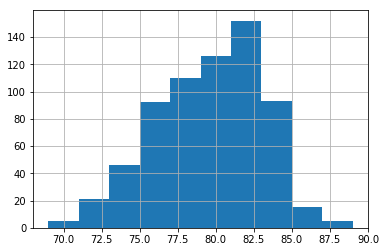

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline  

data_bio.height_in.hist();

### Join Tables

In [41]:
print(data_advanced_15_17.columns)
print(data_per_min_15_17.columns)
print(data_bio.columns)
print(contract_clean.columns)

Index(['Player', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'Year'],
      dtype='object')
Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year'],
      dtype='object')
Index(['bling1', 'bling2', 'name', 'weight', 'height_in', 'Exp_Yrs',
       'College_Ind', 'Award_Ind'],
      dtype='object')
Index(['Player', 'Tm', '2017_18'], dtype='object')


In [42]:
pd.set_option('display.max_columns', 500)


### Merge Stats Data Bio data, then to Contracts Data

In [61]:
print(contract_data.shape[0])
print(contract_data.Year.value_counts())

1353
2016    464
2017    458
2015    431
Name: Year, dtype: int64


In [139]:
contract_data['Player_Match'] = contract_data['Player'].\
                                    apply(lambda x: x.replace("Nene Hilario","Nene").\
                                                      replace("Guillermo Hernangomez","Willy Hernangomez").\
                                                      replace(" III","").\
                                                      replace(" IV","").\
                                                      replace(" Jr.","").upper().\
                                                      replace(".",""))

data_bio['Player_Match'] = data_bio['name'].apply(lambda x: x.replace(" III","").\
                                                              replace(" II","").\
                                                              replace(" IV","").\
                                                              replace(" Jr.","").upper().\
                                                              replace(".",""))

stats_data_all['Player_Match'] = stats_data_all['Player'].apply(lambda x: x.replace(" III","").\
                                                              replace(" II","").\
                                                              replace(" IV","").\
                                                              replace(" Jr.","").upper().\
                                                              replace(".",""))

contract_data.head()

,NAME,TEAM,SALARY,Player,Contract_Yr,Year,Player_Match
0,"Stephen Curry, PG",Golden State Warriors,37457154.0,Stephen Curry,2018,2017,STEPHEN CURRY
1,"Blake Griffin, PF",LA Clippers,32088932.0,Blake Griffin,2018,2017,BLAKE GRIFFIN
2,"Paul Millsap, PF",Denver Nuggets,31269231.0,Paul Millsap,2018,2017,PAUL MILLSAP
3,"Kyle Lowry, PG",Toronto Raptors,31200000.0,Kyle Lowry,2018,2017,KYLE LOWRY
4,"Gordon Hayward, SF",Boston Celtics,29727900.0,Gordon Hayward,2018,2017,GORDON HAYWARD


In [140]:
stats_data_all[stats_data_all['Player_Match'] == 'SERGE IBAKA']

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,USG%_3AVG,OWS_3AVG,DWS_3AVG,WS_3AVG,WS/48_3AVG,OBPM_3AVG,DBPM_3AVG,BPM_3AVG,VORP_3AVG,Player_Match
411,Serge Ibaka,PF,27.0,TOT,79.0,79.0,2422.0,7.0,14.6,0.480,...,19.133333,2.633333,2.766667,5.4,0.111000,-0.700000,0.800000,0.100000,1.233333,SERGE IBAKA
893,Serge Ibaka,PF,26.0,OKC,78.0,78.0,2500.0,6.0,12.5,0.479,...,18.766667,3.533333,3.366667,6.9,0.135000,-0.666667,1.533333,0.866667,1.766667,SERGE IBAKA
1380,Serge Ibaka,PF,25.0,OKC,64.0,64.0,2116.0,6.4,13.4,0.476,...,18.933333,4.466667,3.733333,8.2,0.160333,-0.233333,1.833333,1.600000,2.233333,SERGE IBAKA


In [141]:
Merge_stats_bio = pd.merge(contract_data, data_bio, how='left', on=['Player_Match'])

# Nene Hilario is left as Nene in Basketball reference
# Guillermo Hernangomez in (Contract, ESPN), Willy Hernangomez (bball reference)

In [142]:
y = Merge_stats_bio[Merge_stats_bio.isnull().any(axis=1)]

In [143]:
# List of players with NaNs
print(len(y))
y.Player_Match.unique()

116


array(['BOGDAN BOGDANOVIC', 'MARKELLE FULTZ', 'YI JIANLIAN',
       'BEN SIMMONS', 'LONZO BALL', 'JAYSON TATUM', 'JOSH JACKSON',
       'JONATHAN ISAAC', "DE'AARON FOX", 'LAURI MARKKANEN',
       'FRANK NTILIKINA', 'MALIK MONK', 'LUKE KENNARD', 'DENNIS SMITH',
       'ZACH COLLINS', 'BAM ADEBAYO', 'CEDI OSMAN', 'DONOVAN MITCHELL',
       'DJ WILSON', 'TJ LEAF', 'JUSTIN JACKSON', 'JOHN COLLINS',
       'JUSTIN PATTON', 'GUERSCHON YABUSELE', 'OG ANUNOBY',
       'JARRETT ALLEN', 'ANTE ZIZIC', 'HARRY GILES', 'TERRANCE FERGUSON',
       'FURKAN KORKMAZ', 'JULYAN STONE', 'TYLER LYDON', 'CALEB SWANIGAN',
       'KYLE KUZMA', 'TONY BRADLEY', 'DERRICK WHITE', 'JOSH HART',
       'KHEM BIRCH', 'DWAYNE BACON', 'TYLER DORSEY', 'ANTONIUS CLEVELAND',
       'DAMYEAN DOTSON', 'CARRICK FELIX', 'SEMI OJELEYE',
       'LIVIO JEAN-CHARLES', 'FRANK MASON', 'ABDEL NADER', 'CHRIS WRIGHT',
       'RADE ZAGORAC', 'IVAN RABB', 'KEVIN MURPHY', 'DJ KENNEDY',
       'DJ STEPHENS', 'TROY CAUPAIN', 'DILLON BROOKS'

### Merge data to stats data

In [144]:

Merge_stats_bio_contracts = pd.merge(Merge_stats_bio, stats_data_all, how='left', on=['Player_Match','Year'], )


In [145]:
Merge_stats_bio_contracts.tail(5)

,NAME,TEAM,SALARY,Player_x,Contract_Yr,Year,Player_Match,bling1,bling2,name,...,TOV%_3AVG,USG%_3AVG,OWS_3AVG,DWS_3AVG,WS_3AVG,WS/48_3AVG,OBPM_3AVG,DBPM_3AVG,BPM_3AVG,VORP_3AVG
1348,"Orlando Johnson, SG",Phoenix Suns,55722.0,Orlando Johnson,2016,2015,ORLANDO JOHNSON,None,None,Orlando Johnson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1349,"Phil Pressey, PG",Phoenix Suns,55722.0,Phil Pressey,2016,2015,PHIL PRESSEY,None,None,Phil Pressey,...,20.75,15.70,-0.5,0.9,0.45,0.0325,-3.00,-0.30,-3.30,-0.35
1350,"Elliot Williams, SG",Memphis Grizzlies,55722.0,Elliot Williams,2016,2015,ELLIOT WILLIAMS,None,None,Elliot Williams,...,12.15,16.55,0.0,0.2,0.20,0.0265,-2.45,-2.75,-5.15,-0.60
1351,"Cory Jefferson, F",Phoenix Suns,49709.0,Cory Jefferson,2016,2015,CORY JEFFERSON,None,None,Cory Jefferson,...,9.50,18.10,0.2,0.6,0.80,0.0710,-3.30,-0.40,-3.70,-0.20
1352,"Thanasis Antetokounmpo, SF",New York Knicks,30888.0,Thanasis Antetokounmpo,2016,2015,THANASIS ANTETOKOUNMPO,None,None,Thanasis Antetokounmpo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
Merge_stats_bio_contracts[Merge_stats_bio_contracts.Player_x == 'Serge Ibaka']

,NAME,TEAM,SALARY,Player_x,Contract_Yr,Year,Player_Match,bling1,bling2,name,...,TOV%_3AVG,USG%_3AVG,OWS_3AVG,DWS_3AVG,WS_3AVG,WS/48_3AVG,OBPM_3AVG,DBPM_3AVG,BPM_3AVG,VORP_3AVG
32,"Serge Ibaka, C",Toronto Raptors,21666667.0,Serge Ibaka,2018,2017,SERGE IBAKA,3x All-Defensive,None,Serge Ibaka,...,10.033333,19.133333,2.633333,2.766667,5.4,0.111000,-0.700000,0.800000,0.100000,1.233333
526,"Serge Ibaka, C",Toronto Raptors,12250000.0,Serge Ibaka,2017,2016,SERGE IBAKA,3x All-Defensive,None,Serge Ibaka,...,10.400000,18.766667,3.533333,3.366667,6.9,0.135000,-0.666667,1.533333,0.866667,1.766667
968,"Serge Ibaka, C",Oklahoma City Thunder,12250000.0,Serge Ibaka,2016,2015,SERGE IBAKA,3x All-Defensive,None,Serge Ibaka,...,11.133333,18.933333,4.466667,3.733333,8.2,0.160333,-0.233333,1.833333,1.600000,2.233333


In [148]:
Merge_stats_bio_contracts[Merge_stats_bio_contracts.isnull().any(axis=1)]


,NAME,TEAM,SALARY,Player_x,Contract_Yr,Year,Player_Match,bling1,bling2,name,...,TOV%_3AVG,USG%_3AVG,OWS_3AVG,DWS_3AVG,WS_3AVG,WS/48_3AVG,OBPM_3AVG,DBPM_3AVG,BPM_3AVG,VORP_3AVG
97,"Nikola Pekovic, C",Minnesota Timberwolves,12100000.0,Nikola Pekovic,2018,2017,NIKOLA PEKOVIC,None,None,Nikola Pekovic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,"Bogdan Bogdanovic, SG",Sacramento Kings,9412280.0,Bogdan Bogdanovic,2018,2017,BOGDAN BOGDANOVIC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,"Markelle Fultz, PG",Philadelphia 76ers,8339880.0,Markelle Fultz,2018,2017,MARKELLE FULTZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,"Kevin Garnett, PF",Minnesota Timberwolves,8000000.0,Kevin Garnett,2018,2017,KEVIN GARNETT,15x All Star,2007-08 NBA Champ,Kevin Garnett,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,"Yi Jianlian, SF",Los Angeles Lakers,8000000.0,Yi Jianlian,2018,2017,YI JIANLIAN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,"Festus Ezeli, C",Portland Trail Blazers,7400000.0,Festus Ezeli,2018,2017,FESTUS EZELI,2014-15 NBA Champ,None,Festus Ezeli,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,"Carl Landry, PF",Philadelphia 76ers,6500000.0,Carl Landry,2018,2017,CARL LANDRY,2007-08 All-Rookie,None,Carl Landry,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,"Ben Simmons, PG",Philadelphia 76ers,6434520.0,Ben Simmons,2018,2017,BEN SIMMONS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,"Tim Duncan, C",San Antonio Spurs,6393750.0,Tim Duncan,2018,2017,TIM DUNCAN,15x All Star,5x NBA Champ,Tim Duncan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,"Lonzo Ball, PG",Los Angeles Lakers,6286560.0,Lonzo Ball,2018,2017,LONZO BALL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
# Adjust Exp Column since it's static, but should be ajdusted
def clean_exp(row):
    if row['Year'] == 2016:
        val = row['Exp_Yrs'] - 1 
    elif row['Year'] == 2015:
        val = row['Exp_Yrs'] - 2 
    else:
        val = row['Exp_Yrs']
    return val

# Adjust Exp Column since it's static, but should be ajdusted
def inf_adj(row):
    if row['Year'] == 2016:
        val = row['SALARY'] * 1.07 
    elif row['Year'] == 2015:
        val = row['SALARY'] * (1.07**2)
    else:
        val = row['SALARY']
    return val

def identify_bench(row):
    if row['GS_3AVG'] <= 8:
        val = 1 
    else:
        val = 0
    return val


# DF_Modeling2[DF_Modeling2['Pos'] == 'PG-SG'] -> convert to PG
# DF_Modeling2[DF_Modeling2['Pos'] == 'SG-PG'] -> convert to PG
# DF_Modeling2[DF_Modeling2['Pos'] == 'PF-SF'] -> convert to SF
# DF_Modeling2[DF_Modeling2['Pos'] == 'SF-SG'] -> SG
# DF_Modeling2[DF_Modeling2['Pos'] == 'SF-PF'] --> SF
# DF_Modeling2[DF_Modeling2['Pos'] == 'PF-C'] --> PF

# Adjust Position
def clean_position(row):
    if row['Pos'] == 'SG-PG':
        val = 'PG'
    elif row['Pos'] == 'PG-SG':
        val = 'PG'
    elif row['Pos'] == 'PF-SF':
        val = 'SF'
    elif row['Pos'] == 'SF-SG':
        val = 'SG'
    elif row['Pos'] == 'SG-SF':
        val = 'SF'
    elif row['Pos'] == 'SF-PF':
        val = 'SF'
    elif row['Pos'] == 'PF-C':
        val = 'PF'
    else:
        val = row['Pos']
    return val

In [150]:
# Drop columns with null values
Merge_Dedupe = Merge_stats_bio_contracts.dropna(how='any').copy()

# Need logic to adjust yrs of Exp
Merge_Dedupe['Exp_Yrs_Real'] = Merge_Dedupe.apply(clean_exp, axis=1)

# Need logic to fix Positions to one. (Some players have two)
Merge_Dedupe['Pos'] = Merge_Dedupe.apply(clean_position, axis=1)

Merge_Dedupe['Bench_Player'] = Merge_Dedupe.apply(identify_bench, axis=1) 

# Adjustments to SALARY
Merge_Dedupe['SALARY_M'] = Merge_Dedupe['SALARY'].apply(lambda x: x/1000000)
Merge_Dedupe['SAL_INFL'] = Merge_Dedupe.apply(inf_adj, axis=1)
Merge_Dedupe['SAL_INFL_M'] = Merge_Dedupe['SAL_INFL'].apply(lambda x: x/1000000)
Merge_Dedupe['Log_SAL'] = Merge_Dedupe['SALARY'].apply(lambda x: np.log(x))
Merge_Dedupe['Log_SAL_INFL'] = Merge_Dedupe['SAL_INFL'].apply(lambda x: np.log(x))

# Modeling file
DF_Modeling = Merge_Dedupe.drop(['Age', 'Exp_Yrs', 'Player_x', 'Player_y', 'Year_3AVG', 'Age_3AVG'], 1)

print("Rows before dropping nulls:", Merge_stats_bio_contracts.shape[0])
print("Rows after dropping nulls:", Merge_Dedupe.shape[0])
print("Pct:", Merge_Dedupe.shape[0] / Merge_stats_bio_contracts.shape[0])

# Most of the lost volume is from Rookie contracts that have no NBA playing history

Rows before dropping nulls: 1353
Rows after dropping nulls: 1049
Pct: 0.7753141167775314


In [152]:
DF_Modeling.tail()

,NAME,TEAM,SALARY,Contract_Yr,Year,Player_Match,bling1,bling2,name,weight,...,DBPM_3AVG,BPM_3AVG,VORP_3AVG,Exp_Yrs_Real,Bench_Player,SALARY_M,SAL_INFL,SAL_INFL_M,Log_SAL,Log_SAL_INFL
1343,"Jeff Ayres, F",LA Clippers,111444.0,2016,2015,JEFF AYRES,2013-14 NBA Champ,None,Jeff Ayres,240.0,...,1.033333,-1.366667,0.166667,4.0,1,0.111444,127592.2356,0.127592,11.621278,11.756595
1345,"Erick Green, PG",Utah Jazz,99418.0,2016,2015,ERICK GREEN,None,None,Erick Green,185.0,...,-2.700000,-5.400000,-0.300000,0.0,1,0.099418,113823.6682,0.113824,11.507088,11.642406
1349,"Phil Pressey, PG",Phoenix Suns,55722.0,2016,2015,PHIL PRESSEY,None,None,Phil Pressey,175.0,...,-0.300000,-3.300000,-0.350000,1.0,1,0.055722,63796.1178,0.063796,10.928130,11.063448
1350,"Elliot Williams, SG",Memphis Grizzlies,55722.0,2016,2015,ELLIOT WILLIAMS,None,None,Elliot Williams,190.0,...,-2.750000,-5.150000,-0.600000,2.0,1,0.055722,63796.1178,0.063796,10.928130,11.063448
1351,"Cory Jefferson, F",Phoenix Suns,49709.0,2016,2015,CORY JEFFERSON,None,None,Cory Jefferson,218.0,...,-0.400000,-3.700000,-0.200000,0.0,1,0.049709,56911.8341,0.056912,10.813941,10.949259


In [102]:
pos_dummies = pd.get_dummies(DF_Modeling.Pos).astype(int)
pos_dummies.columns=["Center","PowerFwd", "PointG", "SmallFwd","ShootingG"]
pos_dummies

,Center,PowerFwd,PointG,SmallFwd,ShootingG
922,0,0,0,0,1
923,0,0,0,1,0
924,0,0,0,1,0
925,1,0,0,0,0
926,1,0,0,0,0
927,0,0,1,0,0
928,0,0,0,1,0
929,0,0,1,0,0
930,0,0,0,0,1
931,0,1,0,0,0


In [103]:
# drop one level
pos_dummies = pos_dummies[["Center","PowerFwd", "PointG", "SmallFwd"]]

DF_Modeling = pd.concat([DF_Modeling, pos_dummies], axis=1) 

In [113]:
DF_Modeling.Year.unique()

array([2015])

In [104]:
DF_Modeling.tail(10)

,NAME,TEAM,SALARY,Contract_Yr,Year,Player_Match,bling1,bling2,name,weight,...,Bench_Player,SALARY_M,SAL_INFL,SAL_INFL_M,Log_SAL,Log_SAL_INFL,Center,PowerFwd,PointG,SmallFwd
1336,"Kevin Martin, SG",San Antonio Spurs,200600.0,2016,2015,KEVIN MARTIN,None,None,Kevin Martin,199.0,...,0,0.200600,229666.9400,0.229667,12.209068,12.344385,0,0,0,0
1338,"Jorge Gutierrez, PG",Charlotte Hornets,189455.0,2016,2015,JORGE GUTIERREZ,None,None,Jorge Gutierrez,191.0,...,1,0.189455,216907.0295,0.216907,12.151907,12.287224,0,0,1,0
1340,"Tony Wroten, SG",Philadelphia 76ers,167406.0,2016,2015,TONY WROTEN,None,None,Tony Wroten,205.0,...,0,0.167406,191663.1294,0.191663,12.028177,12.163495,0,0,1,0
1341,"Sean Kilpatrick, G",Brooklyn Nets,134215.0,2016,2015,SEAN KILPATRICK,None,None,Sean Kilpatrick,210.0,...,1,0.134215,153662.7535,0.153663,11.807198,11.942516,0,0,0,0
1342,"Lorenzo Brown, G",Phoenix Suns,111444.0,2016,2015,LORENZO BROWN,None,None,Lorenzo Brown,189.0,...,1,0.111444,127592.2356,0.127592,11.621278,11.756595,0,0,1,0
1343,"Jeff Ayres, F",LA Clippers,111444.0,2016,2015,JEFF AYRES,2013-14 NBA Champ,None,Jeff Ayres,240.0,...,1,0.111444,127592.2356,0.127592,11.621278,11.756595,0,1,0,0
1345,"Erick Green, PG",Utah Jazz,99418.0,2016,2015,ERICK GREEN,None,None,Erick Green,185.0,...,1,0.099418,113823.6682,0.113824,11.507088,11.642406,0,0,1,0
1349,"Phil Pressey, PG",Phoenix Suns,55722.0,2016,2015,PHIL PRESSEY,None,None,Phil Pressey,175.0,...,1,0.055722,63796.1178,0.063796,10.928130,11.063448,0,0,1,0
1350,"Elliot Williams, SG",Memphis Grizzlies,55722.0,2016,2015,ELLIOT WILLIAMS,None,None,Elliot Williams,190.0,...,1,0.055722,63796.1178,0.063796,10.928130,11.063448,0,0,0,0
1351,"Cory Jefferson, F",Phoenix Suns,49709.0,2016,2015,CORY JEFFERSON,None,None,Cory Jefferson,218.0,...,1,0.049709,56911.8341,0.056912,10.813941,10.949259,0,1,0,0


In [105]:
DF_Modeling[DF_Modeling['name'] == 'Stephen Curry']

,NAME,TEAM,SALARY,Contract_Yr,Year,Player_Match,bling1,bling2,name,weight,...,Bench_Player,SALARY_M,SAL_INFL,SAL_INFL_M,Log_SAL,Log_SAL_INFL,Center,PowerFwd,PointG,SmallFwd
974,"Stephen Curry, PG",Golden State Warriors,11370786.0,2016,2015,STEPHEN CURRY,4x All Star,2015-16 NBA Scoring Champ,Stephen Curry,190.0,...,0,11.370786,1.301841e+07,13.018413,16.246558,16.381875,0,0,1,0


#### Pickle data

In [108]:
!pwd

/Users/renkohkato/ds/metisgh/scrapGit/NBA_SalaryPrediction


In [109]:
DF_Modeling.to_pickle('./nba/data/DF_Modeling_revisit.pkl')

In [110]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

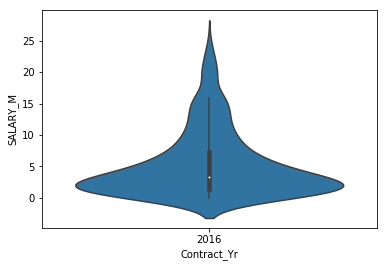

In [111]:
sns.violinplot(data=DF_Modeling, x="Contract_Yr", y="SALARY_M");

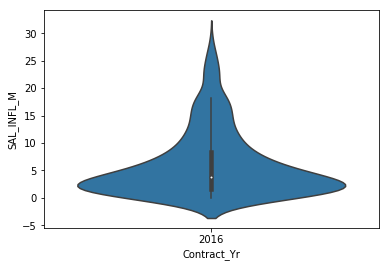

In [112]:
sns.violinplot(data=DF_Modeling, x="Contract_Yr", y="SAL_INFL_M");

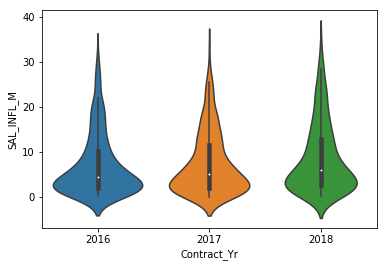

In [171]:
sns.violinplot(data=DF_Modeling, x="Contract_Yr", y="SAL_INFL_M");